In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from collections import Counter
from numpy.random import seed
import tensorflow
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
seed(1)


In [2]:
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_1.csv
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_8.csv
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_65.csv
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_26.csv
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_27.csv
#https://raw.githubusercontent.com/hnunezd/DSI/main/real_31.csv

url="https://raw.githubusercontent.com/hnunezd/DSI/main/real_8.csv"
df = pd.read_csv(url)


,timestamp,value,is_anomaly
0,1,0,0
1,2,33,0
2,3,31,0
3,4,68,0
4,5,63,0
...,...,...,...
1415,1416,1495,0
1416,1417,1605,0
1417,1418,1201,0
1418,1419,916,0


In [3]:
anom=df[df["is_anomaly"]==1]

In [4]:
Counter(df["is_anomaly"])

Counter({0: 1410, 1: 10})

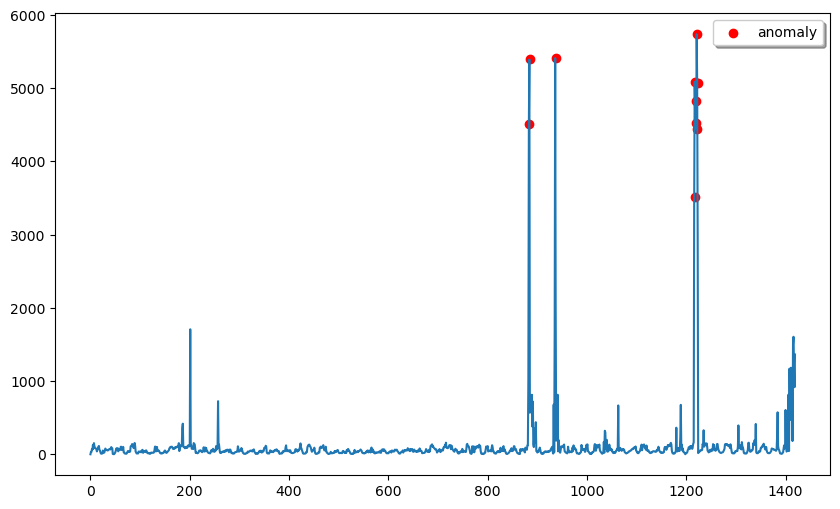

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["value"])
plt.scatter(anom["timestamp"],anom["value"],c="red",label="anomaly")
plt.legend(shadow=True)
plt.show()

In [6]:
values=df.iloc[:,1:2]
target=df["is_anomaly"]

In [7]:
test=int(len(df)*0.5)

In [8]:
x_train=values[:test]
x_test=values[test:len(df)]

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_p = scaler.fit_transform(x_train)

In [10]:
scaled_test = scaler.fit_transform(x_test)

In [11]:
x_train_p, y_train_p = [], []
for i in range(8,len(scaled_data_p)):
    x_train_p.append(scaled_data_p[i-8:i])
    y_train_p.append(scaled_data_p[i])
x_train_p, y_train_p = np.array(x_train_p), np.array(y_train_p)

In [12]:
x_test_p, y_test_p = [], []
for i in range(8,len(scaled_test)):
    x_test_p.append(scaled_test[i-8:i])
    y_test_p.append(scaled_test[i])
x_test_p, y_test_p = np.array(x_test_p), np.array(y_test_p)

In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [14]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
tensorflow.random.set_seed(123)
input_shape = x_train_p.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.4,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, \
    restore_best_weights=True)]

model.fit(
    x_train_p,
    y_train_p,
    validation_split=0.2,
    epochs=200,
    batch_size=60,
    callbacks=callbacks,
)

model.evaluate(x_test_p, y_test_p, verbose=1)

In [17]:
from sklearn import metrics

pred = model.predict(x_test_p)


22/22 [==============================] - 0s 10ms/step


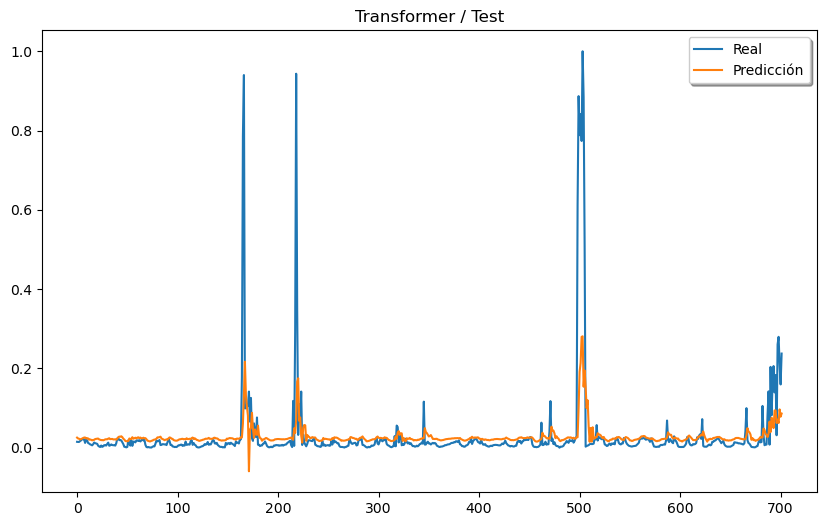

In [18]:
plt.figure(figsize=(10,6))
#plt.xlim(1900,2100)
plt.plot(y_test_p, label="Real")
plt.plot(pred, label="Predicción")
plt.title("Transformer / Test")
plt.legend(shadow=True)
plt.show()

In [19]:
df_1=pd.DataFrame()

In [20]:
df_1["real"]=pd.DataFrame(y_test_p)

In [21]:
df_1["pred"]=pred

In [22]:
df_1["anomaly"]=target[test+8:len(df)].values

In [23]:
df_1["Error"]=(df_1.real-df_1.pred)**2

In [24]:
#anomalias_p = df_1[(df_1.Error < - 3.5*np.std(df_1.Error)) | (df_1.Error > 3.5*np.std(df_1.Error))]
anomalias_p = df_1[df_1.Error > 3.5*np.std(df_1.Error)]

In [25]:
#Potenciales Anomalias identificadas con transformers
anomalias_p

,real,pred,anomaly,Error
165,0.786611,0.060849,1,0.526731
166,0.940028,0.132112,1,0.652728
218,0.943340,0.070134,1,0.762488
498,0.612971,0.026430,1,0.344030
499,0.886855,0.101005,1,0.617560
500,0.788354,0.191440,1,0.356307
501,0.841353,0.213626,1,0.394041
502,0.773710,0.279468,1,0.244275
503,1.000000,0.280986,1,0.516981
504,0.884066,0.153827,1,0.533248


In [26]:
#Total de anomalias reales en Dataset
df_1[df_1["anomaly"]==1]


,real,pred,anomaly,Error
165,0.786611,0.060849,1,0.526731
166,0.940028,0.132112,1,0.652728
218,0.943340,0.070134,1,0.762488
498,0.612971,0.026430,1,0.344030
499,0.886855,0.101005,1,0.617560
500,0.788354,0.191440,1,0.356307
501,0.841353,0.213626,1,0.394041
502,0.773710,0.279468,1,0.244275
503,1.000000,0.280986,1,0.516981
504,0.884066,0.153827,1,0.533248


In [27]:
anom=df_1[df_1["anomaly"] == 1]

In [28]:
df_1["score"] = (df_1["Error"] - np.min(df_1.Error)) / (
    np.max(df_1.Error) - np.min(df_1.Error)
)

In [29]:
df_1["score"].sort_values(ascending=False).head(30)

218    1.000000
166    0.856050
499    0.809927
504    0.699352
165    0.690805
503    0.678018
501    0.516782
500    0.467294
498    0.451193
502    0.320366
505    0.130338
217    0.087193
698    0.062002
171    0.053025
697    0.047259
219    0.044410
690    0.035460
693    0.032122
164    0.030717
701    0.030059
506    0.029430
220    0.026765
167    0.018200
508    0.017142
699    0.016658
223    0.016239
688    0.015073
215    0.012597
692    0.012090
507    0.011946
Name: score, dtype: float64

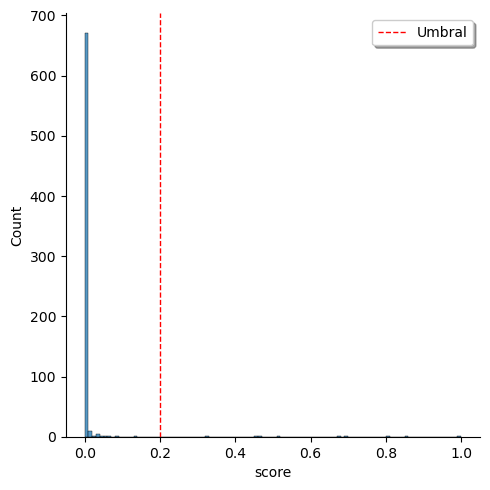

In [30]:
sns.displot(data=df_1, x="score",bins=100)
plt.axvline(0.2, color="red", linewidth = 1, linestyle = "dashed",label="Umbral");
plt.legend(shadow=True)
#plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/trans_umbral_27.pdf")
plt.show()

In [31]:
umbral = 0.2

In [32]:
df_1["pred_score"] = np.where(df_1.score > umbral, 1, 0)

In [33]:
df_1[df_1["pred_score"] == 1]

,real,pred,anomaly,Error,score,pred_score
165,0.786611,0.060849,1,0.526731,0.690805,1
166,0.940028,0.132112,1,0.652728,0.856050,1
218,0.943340,0.070134,1,0.762488,1.000000,1
498,0.612971,0.026430,1,0.344030,0.451193,1
499,0.886855,0.101005,1,0.617560,0.809927,1
500,0.788354,0.191440,1,0.356307,0.467294,1
501,0.841353,0.213626,1,0.394041,0.516782,1
502,0.773710,0.279468,1,0.244275,0.320366,1
503,1.000000,0.280986,1,0.516981,0.678018,1
504,0.884066,0.153827,1,0.533248,0.699352,1


In [34]:
print(classification_report(df_1.anomaly, df_1.pred_score))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       692
           1       1.00      1.00      1.00        10

    accuracy                           1.00       702
   macro avg       1.00      1.00      1.00       702
weighted avg       1.00      1.00      1.00       702



In [35]:
anom_score=df_1[df_1["pred_score"] == 1]

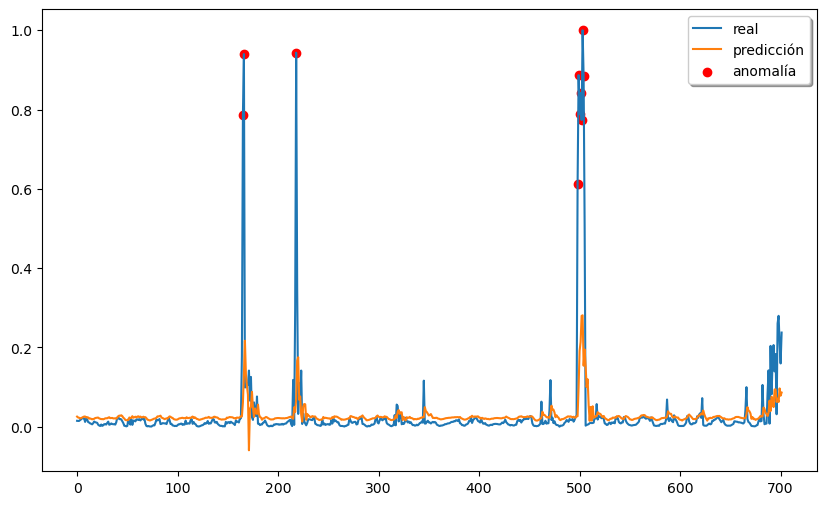

In [36]:
plt.figure(figsize=(10, 6))
# plt.xlim(1900,2100)
plt.plot(y_test_p, label="real")
plt.plot(pred,label="predicción")
plt.scatter(anom.index, anom.real, c="red",label="anomalía")
#plt.scatter(anom_score.index, anom_score.real, c="#00ff80", alpha=0.7,marker="*",label="posible anomalía")
plt.legend(shadow=True)
#plt.savefig("/Users/hn/OneDrive/Doctorado/Tesis/Proyecto Tesis/fig_examen/trans_score31.pdf")
plt.show()